# ***Volume Detection Neuronal Network training (Third Inference Test)***

## Notebook training with 1 to 21 cases and 63 case, infering with the rest of cases

Montamos Google Drive para acceder a nuestros archivos directamente desde Google Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Intentar instalar la versión 2.15 de TensorFlow para una correcta compatibilidad con TFLite (en Spyder se utilizó una librería Scikeras que permite GridSearch y su uso incompatibiliza las versiones de TensorFlow y TensorFlow Lite).

In [ ]:
!pip install tensorflow==2.15

Ahora se configura el entorno para un proyecto de machine learning que utiliza Scikit-Learn y TensorFlow. Se asegura que se esté usando Python ≥3.5 y Scikit-Learn ≥0.20. Se importan los módulos necesarios para tareas como división de datos, procesamiento, creación de pipelines, evaluación de modelos y búsqueda de hiperparámetros. Además, se importan TensorFlow y Keras (≥2.0), se limpia la sesión backend de Keras, se establecen semillas aleatorias para reproducibilidad y se configura Matplotlib para generar gráficos. Se definen rutas para guardar figuras y modelos, y se asegura que el conjunto de datos CSV esté accesible desde Google Drive.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import RandomizedSearchCV

# Tensorflow >= 2.0 required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from tensorboard import program

keras.backend.clear_session()

# Common imports
import numpy as np
import os
from scipy.stats import randint
from scipy import stats

# to make this script's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import joblib
from copy import deepcopy
from functools import partial

# Where to save the figures
PROJECT_ROOT_DIR = "./drive/MyDrive"
CHAPTER_ID = "Deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "VolumeImages", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Root to dataset csv
DATASET_PATH = "./drive/MyDrive"
MODELS_PATH = "./drive/MyDrive/VolumeModels"

## Data collection and visualization functions

En esta sección se extraerá y visualizará el conjunto de datos, finalizando con una división en dos conjuntos: el conjunto de entrenamiento y el conjunto de prueba, los cuales se utilizarán para entrenar y predecir datos de la salida del procesamiento.

La función **save_fig** guarda una figura de Matplotlib como un archivo de imagen. Construye la ruta del archivo para guardar la figura e imprime un mensaje indicando que se está guardando la figura. Si se especifica, ajusta los parámetros de los subgráficos para un ajuste más cómodo. Finalmente, guarda la figura en la ruta especificada con el formato y la resolución dados.

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

La función **load_sensor_data** carga un conjunto de datos almacenado en un archivo CSV ubicado en la ruta especificada por dataset_path (por defecto es **DATASET_PATH**). Construye la ruta al archivo CSV uniendo dataset_path con el nombre de archivo **"VolumeDataset.csv"**. Luego, lee el archivo CSV utilizando pd.read_csv() de la biblioteca Pandas y devuelve los datos como un objeto DataFrame.

Finalmente, el conjunto de datos cargado se asigna a la variable **laser_data**.

In [ ]:
def load_sensor_data(dataset_path = DATASET_PATH):
    csv_path = os.path.join(dataset_path, "VolumeDataset.csv")
    # Devuelve un objeto DataFrame de la librería Pandas con todos los datos
    return pd.read_csv(csv_path)

laser_data = load_sensor_data()

La función **split_train_test** divide los datos de entrada data en conjuntos de entrenamiento y prueba basados en el **test_ratio** especificado. Primero, baraja los índices de los datos utilizando np.random.permutation(). Luego, calcula el tamaño del conjunto de prueba en función del ratio de prueba y selecciona los índices para el conjunto de prueba a partir de los índices barajados. Los índices restantes se asignan al conjunto de entrenamiento. Finalmente, devuelve las porciones de los datos correspondientes a los índices seleccionados tanto para el conjunto de entrenamiento como para el de prueba. Esta es una función programada por el usuario, aunque existe una función en **sklearn** que realiza una división similar (**train_test_split()**).

In [ ]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

La función **volume_cat_proportions** calcula las proporciones de las diferentes categorías en la columna "volTotal_cat" de los datos de entrada **data**. Utiliza el método **value_counts()** para contar las ocurrencias de cada categoría y divide los recuentos por la longitud total de los datos para obtener las proporciones. Finalmente, devuelve una Serie que contiene las proporciones de cada categoría.

In [ ]:
def volume_cat_proportions(data):
    return data["volTotal_cat"].value_counts() / len(data)

La función **showSensorInfo** proporciona una visión general de los datos de entrada **data**. Muestra las primeras filas del conjunto de datos, seguidas de información sobre la estructura del conjunto de datos y los tipos de datos utilizando el método **info()**. Además, imprime los recuentos de diferentes valores en la columna "volTotal" para proporcionar información sobre la distribución de los datos de volumen. Por último, presenta un resumen de los valores numéricos en el conjunto de datos, incluyendo medidas como la media, la mediana, el mínimo y el máximo, utilizando el método **describe()**.

In [ ]:
def showSensorInfo(data):
    print(f'Dataset head:\n {data.head()}\n')
    print(f'Dataset info:\n {data.info()}\n')
    print(f'Volume counts:\n {data["volTotal"].value_counts()}\n')
    print(f'Numeric value resume:\n {data.describe()}\n')

showSensorInfo(laser_data)

La función **plotHistogram** visualiza la distribución de los datos creando un histograma. Se utiliza la función hist de Matplotlib para crear el histograma, con el número de bins establecido para segmentar la variable. El gráfico resultante se guarda utilizando la función **save_fig** y luego se muestra.

In [ ]:
def plotHistogram(data, filename):
    plt.figure()
    data.hist(bins = 50, figsize = (20, 15)) # bins is the number of segments to divide the variable
    save_fig(filename)
    plt.show()

plotHistogram(laser_data, "attribute_histogram_plots")

La función **customRangeSplit** divide los datos en conjuntos de entrenamiento y prueba según un rango específico de valores para la columna 'case'. Primero, identifica los índices de los casos cuyos valores en 'case' están dentro del rango especificado en **test_range**. Luego, crea conjuntos de entrenamiento y prueba excluyendo y conservando respectivamente los casos correspondientes. Después de eliminar la columna 'is_test', si existe, convierte los conjuntos en listas de filas, las baraja y las convierte nuevamente en DataFrames para devolver los conjuntos de entrenamiento y prueba barajados.

In [ ]:
import random
def customRangeSplit(data, test_range):
    # Identificar los índices de los casos para el conjunto de prueba
    test_indices = data[data['case'].between(test_range[0], test_range[1])].index

    # Crear una copia del DataFrame original para los conjuntos de entrenamiento y prueba
    train_set = data[~data.index.isin(test_indices)].copy()
    test_set = data[data.index.isin(test_indices)].copy()

    # Eliminar la columna 'is_test'
    train_set.drop(columns=['is_test'], inplace=True, errors='ignore')
    test_set.drop(columns=['is_test'], inplace=True, errors='ignore')

    # Convertir DataFrames a listas de filas
    train_set_list = train_set.values.tolist()
    test_set_list = test_set.values.tolist()

    # Barajar las listas
    random.shuffle(train_set_list)
    random.shuffle(test_set_list)

    # Convertir las listas barajadas de vuelta a DataFrames
    train_set = pd.DataFrame(train_set_list, columns=train_set.columns)
    test_set = pd.DataFrame(test_set_list, columns=test_set.columns)

    if 'case' in train_set.columns:
        train_set['case'] = train_set['case'].astype(int)
    if 'case' in test_set.columns:
        test_set['case'] = test_set['case'].astype(int)

    return train_set, test_set

# Ejemplo de uso
train_set, test_set = customRangeSplit(laser_data, test_range=(22, 62))

La función **getPearson** calcula los coeficientes de correlación de Pearson entre la **variable** especificada y todas las demás variables en el conjunto de datos **data**. Calcula la matriz de correlación utilizando el método corr() y luego imprime los coeficientes de correlación de la variable con todas las demás variables ordenadas en orden descendente. Esto proporciona información sobre la fuerza y la dirección de las relaciones lineales entre la variable y las demás variables en el conjunto de datos.

In [ ]:
def getPearson(data, variable):
    corr_matrix = data.corr()
    print(corr_matrix[variable].sort_values(ascending = False))

## Dataset preprocessing, depuration and preparation functions

Ahora es el momento de preprocesar los datos del conjunto de entrenamiento, preparándolos y depurándolos para un uso correcto y mejorado más adelante.

Primero, prepararemos el conjunto de entrenamiento definiendo una lista de columnas a eliminar. Solo necesitamos los datos de los sensores A y B. Luego, eliminaremos estas columnas especificadas del **train_set**, almacenando las características restantes en **laser_data**. Además, extraeremos la columna "**FreeSpace**" del train_set y la almacenaremos en **laser_data_labels**, que se utilizará como la variable *target* para el modelo de regresión.

In [ ]:
# Get data labels
datatodrop = ["case", "vol1", "vol2", "vol3", "vol4", "vol5", "vol6", "volTotal", "FreeSpace"]
laser_data = train_set.drop(datatodrop, axis = 1)
laser_data_labels = train_set["FreeSpace"].copy()

La función **datasetDepuration** limpia el conjunto de datos identificando filas con valores faltantes y reemplazando esos valores faltantes con la mediana de las columnas respectivas. Luego, imprime las filas con valores faltantes, los valores medianos utilizados para la imputación y las primeras filas del conjunto de datos limpio. Esto prepara los datos para un análisis adicional o el entrenamiento del modelo.

In [ ]:
def datasetDepuration(data):
    sample_incomplete_rows = data[data.isnull().any(axis = 1)].head()
    print(f'Incomplete rows:\n {sample_incomplete_rows}\n')

    imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
    imputer.fit(data)
    print(f'Imputer statistics:\n {imputer.statistics_}\n')
    # Same value as median calculations
    # print(f'Median data calculation:\n {data.median().values}\n')

    # Replace nan values with medians
    X = imputer.transform(data)
    laser_data_tr = pd.DataFrame(X, columns = data.columns, index = list(data.index.values))
    print(laser_data_tr.loc[sample_incomplete_rows.index.values])
    print(f'Imputer strategy:\n {imputer.strategy}\n')

    # Save a copy of de train examples numeric values matrix
    laser_data_tr = pd.DataFrame(X, columns = data.columns)
    print(laser_data_tr.head())

# Dataset depuration
datasetDepuration(laser_data)

La función **scaleDataset** preprocesa el conjunto de datos tratando los valores faltantes y escalando las características numéricas. Crea un pipeline para primero reemplazar los valores faltantes con la mediana y luego estandarizar las características. Este conjunto de datos transformado se imprime y luego se prepara para su uso adicional con un pipeline completo que maneja tanto atributos numéricos como no numéricos, en caso de que el conjunto de datos contenga algunos de estos últimos. Finalmente, devuelve el **pipeline completo** de preprocesamiento y el conjunto de datos escalado.

In [ ]:
def scaleDataset(data):
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy = "median")),
        ('std_scaler', StandardScaler()),
        ])
    laser_data_trans = num_pipeline.fit_transform(data)
    print(f'Dataset scaled:\n {laser_data_trans}\n')

    # Dataset numeric attributes
    num_attribs = list(data)

    # Full pipeline with numeric and not numeric attributes
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ])

    laser_prepared = full_pipeline.fit_transform(data)

    return full_pipeline, laser_prepared

# Scale data
full_pipeline, laser_prepared = scaleDataset(laser_data)

La función **getPCA** realiza Análisis de Componentes Principales (PCA, por sus siglas en inglés) en el conjunto de datos para reducir su dimensionalidad mientras se retiene el 95% de la varianza. Transforma el conjunto de datos en un número reducido de componentes y muestra el número de componentes PCA y la varianza acumulada explicada. Finalmente, devuelve el conjunto de datos reducido.

In [ ]:
def getPCA(data):
    pca = PCA(n_components = 0.95) # 95% variance
    data_reduced = pca.fit_transform(data)

    print(f'PCA components number: {pca.n_components_}')
    print(f'Accumulated variance: {np.sum(pca.explained_variance_ratio_)}')

    return data_reduced

# PCA analysis
data_reduced = getPCA(laser_prepared)
print(data_reduced)

## Regression Neural Network functions

La función **create_regression_model** construye y compila un modelo de red neuronal flexible para tareas de regresión, que puede incluir capas convolucionales o densas si se desea. Permite la personalización de varios parámetros, incluyendo la tasa de aprendizaje, el número de capas convolucionales y densas, la cantidad de filtros por capa convolucional, la cantidad de unidades por capa densa y la tasa de dropout.

A continuación, se indicará un resumen paso a paso de lo que hace la función:

1. *Definición de DefaultConv1D*: Define una capa convolucional 1D predeterminada con un tamaño de kernel, una función de activación y el tipo de relleno.
2. *Inicialización del Modelo*: Inicializa un modelo secuencial de Keras.
3. *Capas Convolucionales*:
Itera a través del número especificado de capas convolucionales.
Añade una capa convolucional, duplicando la cantidad de filtros para cada capa subsiguiente y una capa de max pooling después de cada capa convolucional.
4. *Capa de Aplanamiento (Flattening Layer)*: Añade una capa de aplanamiento para convertir la salida 2D de las capas convolucionales en un vector 1D.
5. *Capas Densas*:
Itera a través del número especificado de capas densas.
Añade una capa densa con una función de activación, reduciendo a la mitad la cantidad de unidades para cada capa subsiguiente y una capa de dropout para prevenir el sobreajuste.
6. *Capa de Salida*: Añade una capa densa con una sola unidad para la salida de regresión.
7. *Compilación del Modelo*: Compila el modelo con la función de pérdida de error cuadrático medio (MSE), un optimizador con la tasa de aprendizaje especificada y el error absoluto medio (MAE) como métrica.

La función devuelve el modelo compilado listo para entrenar en tareas de regresión.

In [ ]:
def create_regression_model(learning_rate, num_conv_layers, num_dense_layers, filters_per_conv, units_per_dense, dropout_rate):
    DefaultConv1D = partial(keras.layers.Conv1D,
                        kernel_size=3, kernel_regularizer=keras.regularizers.l2(0.0002), activation='elu', padding="SAME")
    model = keras.models.Sequential()

    # Añadir capas convolucionales
    if num_conv_layers > 0:
      for i in range(num_conv_layers):
          if i == 0:
              model.add(DefaultConv1D(filters=filters_per_conv, input_shape = [128, 1]))
          else:
              filters_per_conv *= 2
              for j in range(1):
                model.add(DefaultConv1D(filters=filters_per_conv))
          model.add(keras.layers.MaxPooling1D(pool_size=2))

      model.add(keras.layers.Flatten())

    # Añadir capas densas
    if num_conv_layers < 1:
        for i in range(num_dense_layers):
          if i == 0:
            model.add(keras.layers.Dense(units=units_per_dense, activation = "elu", input_shape = [128, 1]))
          else:
            units_per_dense = units_per_dense // 2
            model.add(keras.layers.Dense(units=units_per_dense, activation='elu'))
          model.add(keras.layers.Dropout(dropout_rate))
    else:
        for i in range(num_dense_layers):
            model.add(keras.layers.Dense(units=units_per_dense, activation='elu'))
            units_per_dense = units_per_dense // 2
            model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(units=1))  # Capa de salida para la regresión

    model.compile(loss = "mse", optimizer = keras.optimizers.Nadam(learning_rate=learning_rate), metrics=['mae'])  # Utilizar MSE para regresión

    return model

Ahora es posible entrenar el modelo creado proporcionando los parámetros necesarios y mostrando el resumen del modelo obtenido. El conjunto de entrenamiento se divide en dos conjuntos, uno para **train** y otro para **validation** (para una correcta selección de hiperparámetros). El conjunto de entrenamiento será el 80% del conjunto y el de validación el otro 20%.

Se van a declarar algunos **callbacks** para el entrenamiento, como **checkpoint** para guardar el mejor modelo y un **early_stopping** para prevenir el **overfitting**. Finalmente, el modelo se entrena con la función **fit** y se grafican las curvas de aprendizaje, para visualizar el proceso de entrenamiento y los resultados obtenidos.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 128, 2)            8         
                                                                 
 max_pooling1d_15 (MaxPooli  (None, 64, 2)             0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 64, 4)             28        
                                                                 
 max_pooling1d_16 (MaxPooli  (None, 32, 4)             0         
 ng1D)                                                           
                                                                 
 conv1d_17 (Conv1D)          (None, 32, 8)             104       
                                                                 
 max_pooling1d_17 (MaxPooli  (None, 16, 8)            

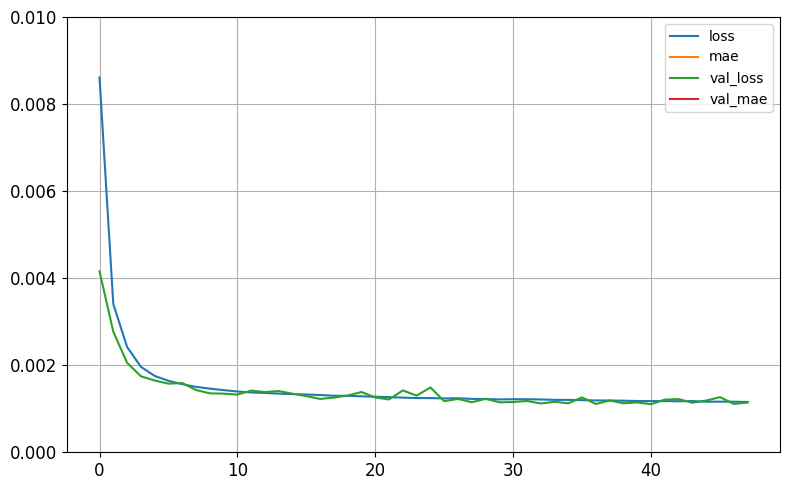

In [ ]:
model = create_regression_model(0.002, 4, 0, 2, 0, 0.2) # Model without 22-62 boxes cases
print(f'Model Summary: {model.summary()}')
data_train, data_val, labels_train, labels_val = train_test_split(laser_prepared, laser_data_labels, test_size = 0.2, random_state = 10)

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath = os.path.join(MODELS_PATH, "model_1and21boxes_FS.keras"),
                                                save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 7,
                                                  restore_best_weights = True)
history = model.fit(data_train, labels_train, epochs = 150, batch_size = 32,
                    validation_data = (data_val, labels_val),
                    callbacks = [checkpoint_cb, early_stopping_cb])

pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.01)
save_fig("Learning_curves_plot_1and21boxes_FS")
plt.show()

La función **modelEvaluation** evalúa el rendimiento del modelo utilizando el conjunto de **test**. Primero, prepara los datos de prueba eliminando las columnas no deseadas y transformándolos utilizando un pipeline de preprocesamiento. Luego, calcula el error cuadrático medio (MSE) del modelo en los datos de prueba. Posteriormente, realiza predicciones en un subconjunto de datos y las compara con las etiquetas verdaderas, imprimiendo una tabla que muestra las etiquetas de prueba y las predicciones correspondientes. Esto permite visualizar cómo se comparan las predicciones del modelo con los valores reales.

In [ ]:
def modelEvaluation(model, test_data, pipeline):
    datatodrop = ["case", "vol1", "vol2", "vol3", "vol4", "vol5", "vol6", "volTotal", "FreeSpace"]
    X_test = test_data.drop(datatodrop, axis = 1)
    y_test = test_data["FreeSpace"].copy()

    X_test_prepared = pipeline.transform(X_test)
    mse_test = model.evaluate(X_test_prepared, y_test)
    data_new = X_test_prepared[:30]
    labels_pred = model.predict(data_new)
    print(f'MSE TEST: {mse_test}')
    '''
    print(f'{"Test label:":<20}{"Test prediction:":<20}')
    for label, prediction in zip(y_test.iloc[:30], [pred[0] for pred in labels_pred]):
        print(f'{label:<20}{prediction:<20}')
    '''
    from tabulate import tabulate

    # Crear una lista de tuplas con las etiquetas y las predicciones
    data = [(label, prediction) for label, prediction in zip(y_test.iloc[:30], [pred[0] for pred in labels_pred])]

    # Imprimir la tabla
    print(tabulate(data, headers=["Test label", "Test prediction"], tablefmt="pretty"))

model_saved = keras.models.load_model(os.path.join(MODELS_PATH, "model_1and21boxes_FS.keras"))
modelEvaluation(model_saved, test_set, full_pipeline)

1/1 [==============================] - 0s 177ms/step
MSE TEST: [0.005691885482519865, 0.04947015643119812]
+------------+---------------------+
| Test label |   Test prediction   |
+------------+---------------------+
|  0.47583   | 0.40858355164527893 |
|  0.84318   | 0.7774047255516052  |
|  0.46352   | 0.4494243562221527  |
|  0.46664   | 0.34713414311408997 |
|  0.29556   | 0.3044307827949524  |
|  0.85884   |  0.839350163936615  |
|  0.36633   | 0.3929562568664551  |
|   0.3227   | 0.32498374581336975 |
|  0.83398   | 0.7688524723052979  |
|  0.51864   | 0.5201011896133423  |
|  0.79798   | 0.7724456191062927  |
|  0.77001   | 0.7776333093643188  |
|  0.76082   | 0.6980952024459839  |
|  0.73368   | 0.6410679817199707  |
|  0.43867   | 0.5150120258331299  |
|  0.83398   | 0.7996135950088501  |
|  0.39586   | 0.4227064251899719  |
|  0.43867   | 0.4985431134700775  |
|  0.51864   | 0.5434432029724121  |
|  0.77001   | 0.7329198718070984  |
|  0.46352   | 0.4579104781150818  |
|  0.

La función **modelEvaluation** evalúa el rendimiento de un modelo utilizando el conjunto de **test**. Primero, prepara los datos de prueba eliminando las columnas no deseadas y transformándolos utilizando un pipeline de preprocesamiento. Luego, calcula el error cuadrático medio (MSE) del modelo en los datos de prueba y realiza predicciones en todo el conjunto.

A continuación, los agrupa por el valor de la columna "case" y calcula estadísticas sobre las predicciones realizadas por el modelo para cada grupo. Estas estadísticas incluyen el error porcentual medio, la desviación estándar del error porcentual y la precisión. Posteriormente, imprime las estadísticas calculadas y visualiza el error porcentual medio para cada grupo utilizando gráficos de barras y diagramas de caja con la ayuda de la biblioteca *Seaborn*. Esto proporciona una comprensión detallada del rendimiento del modelo en diferentes grupos de datos, permitiendo la identificación de posibles patrones o áreas de mejora en la predicción del modelo.

3075/3075 [==============================] - 9s 3ms/step
R² TEST (calculado): 0.8794
MSE TEST: [0.005691887345165014, 0.04947018623352051]
Mean Percentage Errors: 9.166565853658536
Mean Std Dev Errors: 7.07780731707317
Mean Accuracy: 90.83343414634147

Pearson Correlation with 'FreeSpace_real':
FreeSpace_real    1.000000
FreeSpace_pred    0.944401
Name: FreeSpace_real, dtype: float64
+------+-----------+-----------+----------+------------+-----------+---------+
| Caso | FreeSpace | GroupMean | GroupStd | MeanErr(%) | ErrStd(%) | Accu(%) |
+------+-----------+-----------+----------+------------+-----------+---------+
|  22  |   0.914   |  0.9101   |  0.0223  |   1.9844   |  1.4812   | 98.0156 |
|  23  |   0.886   |  0.8657   |  0.0401  |   3.8263   |  3.3371   | 96.1737 |
|  24  |   0.841   |  0.7628   |  0.1207  |  11.3695   |  12.7654  | 88.6305 |
|  25  |   0.519   |  0.4303   |  0.1121  |  22.2119   |  16.2487  | 77.7881 |
|  26  |   0.859   |   0.798   |  0.0622  |   7.7787   |  6.

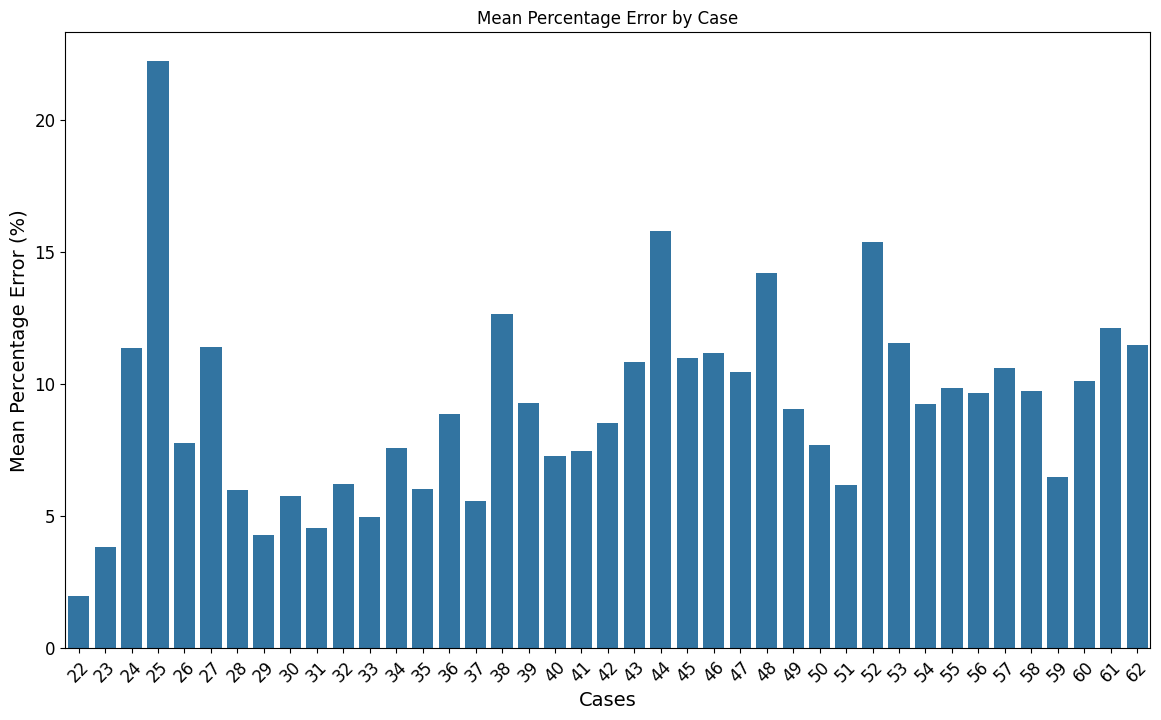

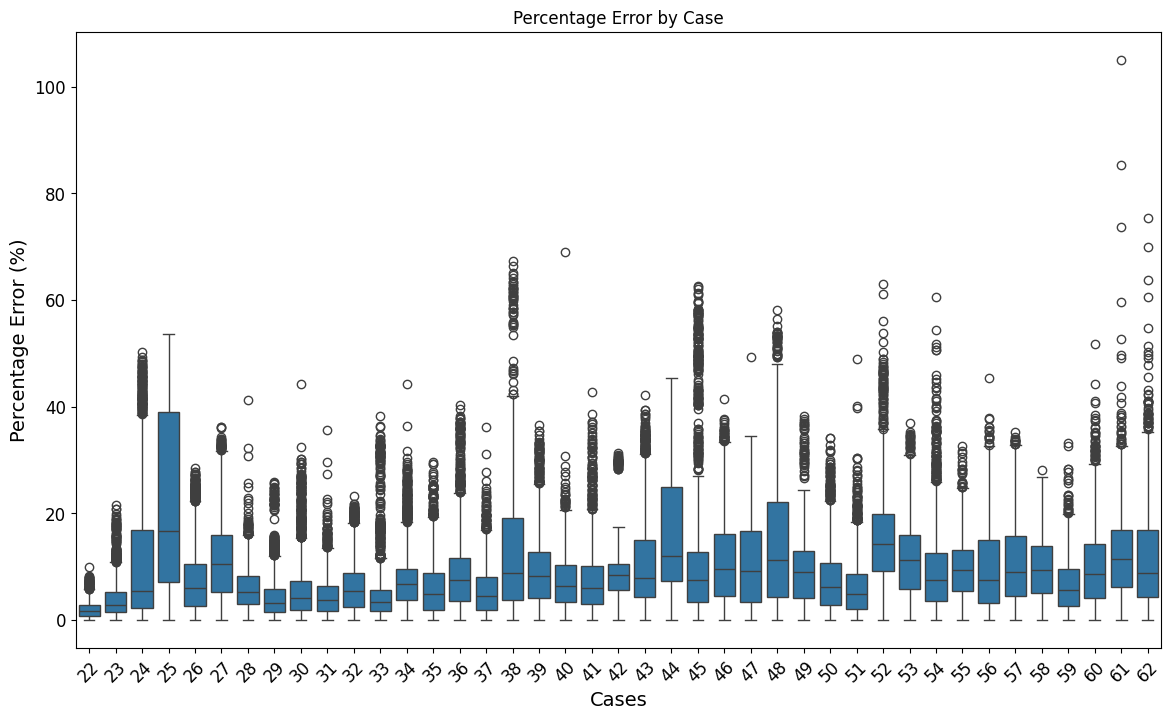

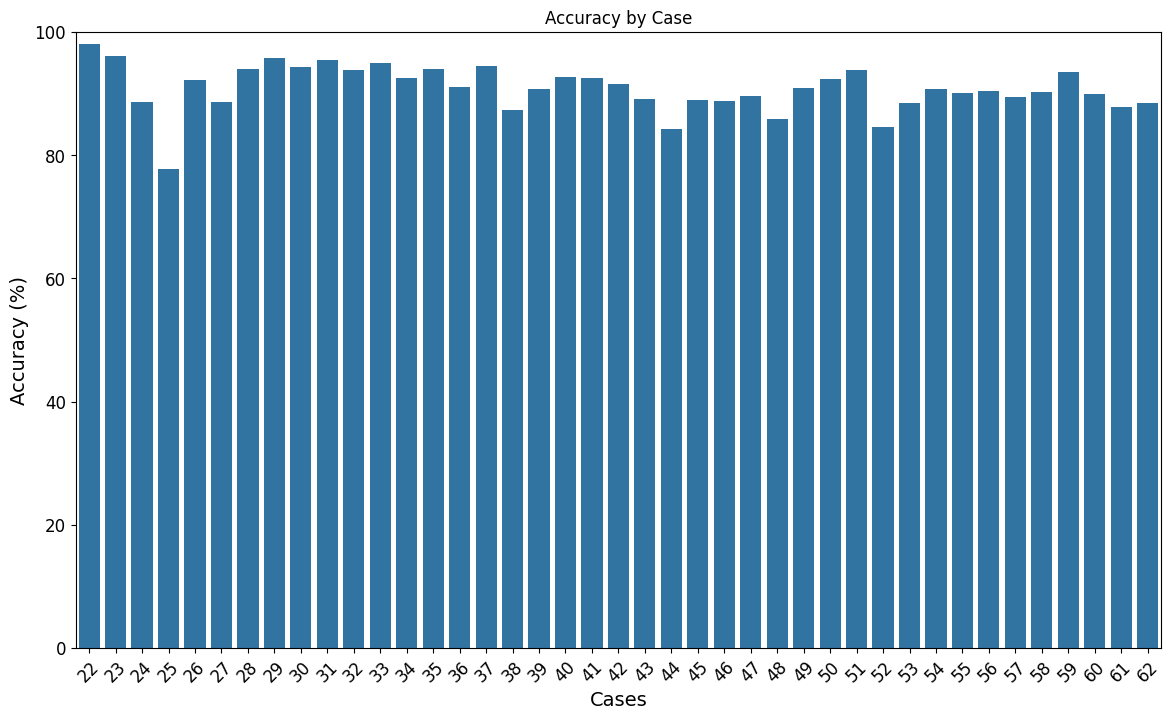

In [ ]:
def modelEvaluation(model, test_data, pipeline):
    datatodrop = ["case", "vol1", "vol2", "vol3", "vol4", "vol5", "vol6", "volTotal", "FreeSpace"]
    X_test = test_data.drop(datatodrop, axis = 1)
    y_test = test_data["FreeSpace"].copy()
    cases = test_data["case"].copy()

    X_test_prepared = pipeline.transform(X_test)
    mse_test = model.evaluate(X_test_prepared, y_test)
    #data_new = X_test_prepared[:30]
    labels_pred = model.predict(X_test_prepared)

    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, labels_pred)
    print(f"R² TEST (calculado): {r2:.4f}")

    # Combine predictions with true values and volTotal
    data = list(zip(cases, y_test, [pred[0] for pred in labels_pred]))

    # Group data by volTotal value
    grouped_data = {}
    for caso, volTotal, pred in data:
        if caso not in grouped_data:
            grouped_data[caso] = []
        grouped_data[caso].append((volTotal, pred))

    # Calculate mean and standard deviation for each group
    group_stats = {}
    for caso, vol_preds in grouped_data.items():
        vols = [vol for vol, _ in vol_preds]
        preds = [float(pred) for _, pred in vol_preds]
        percentage_errors = [(abs(vol - pred) / vol) * 100 for vol, pred in vol_preds]
        acc = [(1 - abs(vol - pred) / vol) * 100 for vol, pred in vol_preds]
        group_stats[caso] = {
            'mean_volTotal': round(vols[0], 3),
            'mean': round(np.mean(preds), 4),
            'std': round(np.std(preds), 4),
            'mean_percentage_error': round(np.mean(percentage_errors), 4),
            'error_std': round(np.std(percentage_errors), 4),
            'accuracy': round(np.mean(acc), 4)
        }

    # Calculate the mean of the mean percentage errors
    mean_percentage_errors = [stats['mean_percentage_error'] for stats in group_stats.values()]
    mean_of_mean_percentage_errors = np.mean(mean_percentage_errors)

    mean_std_dev_errors = [stats['error_std'] for stats in group_stats.values()]
    mean_of_mean_std_dev_errors = np.mean(mean_std_dev_errors)

    mean_accuracy = [stats['accuracy'] for stats in group_stats.values()]
    mean_of_mean_accuracy = np.mean(mean_accuracy)

    print(f'MSE TEST: {mse_test}')
    print(f'Mean Percentage Errors: {mean_of_mean_percentage_errors}')
    print(f'Mean Std Dev Errors: {mean_of_mean_std_dev_errors}')
    print(f'Mean Accuracy: {mean_of_mean_accuracy}')

    df_eval = pd.DataFrame({
        'FreeSpace_real': y_test.values,
        'FreeSpace_pred': labels_pred.flatten()
    })

    print("\nPearson Correlation with 'FreeSpace_real':")
    getPearson(df_eval, 'FreeSpace_real')
    '''
    print(f'{"Test label:":<20}{"Test prediction:":<20}')
    for label, prediction in zip(y_test.iloc[:30], [pred[0] for pred in labels_pred]):
        print(f'{label:<20}{prediction:<20}')
    '''
    from tabulate import tabulate
    import seaborn as sns
    # Combine predictions, true values, and group stats into a list of tuples
    table_data = []
    for caso, stats in sorted(group_stats.items()):
        mean_volTotal = stats['mean_volTotal']
        mean = stats['mean']
        std = stats['std']
        mean_percentage_error = stats['mean_percentage_error']
        error_std = stats['error_std']
        accuracy = stats['accuracy']
        if accuracy < 0:
          accuracy = 0.0
        table_data.append((caso, mean_volTotal, mean, std, mean_percentage_error, error_std, accuracy))

    # Print the table
    headers = ["Caso", "FreeSpace", "GroupMean", "GroupStd", "MeanErr(%)", "ErrStd(%)", "Accu(%)"]
    print(tabulate(table_data, headers=headers, tablefmt="pretty"))

    # Create a DataFrame for visualization
    all_data = []
    for caso, vol_preds in grouped_data.items():
      for vol, pred in vol_preds:
        percentage_error = (abs(vol - pred) / vol) * 100
        all_data.append((caso, percentage_error))

    df_all_data = pd.DataFrame(all_data, columns = ['case', 'percentage_error'])
    df_stats = pd.DataFrame.from_dict(group_stats, orient = 'index').reset_index()
    df_stats.rename(columns={'index': 'case'}, inplace = True)

    # Plotting with Seaborn
    plt.figure(figsize = (14, 8))
    sns.barplot(x = 'case', y = 'mean_percentage_error', data = df_stats)
    plt.xlabel('Cases')
    plt.ylabel('Mean Percentage Error (%)')
    plt.title('Mean Percentage Error by Case')
    plt.xticks(rotation = 45)
    plt.show()

    plt.figure(figsize = (14, 8))
    sns.boxplot(x = 'case', y = 'percentage_error', data = df_all_data)
    # sns.stripplot(x = 'case', y = 'percentage_error', data = df_all_data, color = 'red', alpha = 0.5, jitter = True)
    plt.xlabel('Cases')
    plt.ylabel('Percentage Error (%)')
    plt.title('Percentage Error by Case')
    plt.xticks(rotation = 45)
    plt.show()

    plt.figure(figsize = (14, 8))
    sns.barplot(x='case', y='accuracy', data=df_stats)
    plt.xlabel('Cases')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy by Case')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.show()

    '''
    # Crear una lista de tuplas con las etiquetas y las predicciones
    data = [(label, prediction) for label, prediction in zip(y_test.iloc[:30], [pred[0] for pred in labels_pred])]

    # Imprimir la tabla
    print(tabulate(data, headers=["Test label", "Test prediction"], tablefmt="pretty"))
    '''
model_saved = keras.models.load_model(os.path.join(MODELS_PATH, "model_1and21boxes_FS.keras"))
modelEvaluation(model_saved, test_set, full_pipeline)